# **PicoScope**: efficiencies and source isotropy

## Preliminary operations

### Paths

In [1]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "data/pico_eff_201120/"
SAVE_PATH = "../../plots/data/picoscope/"

### Flags

In [2]:
UNZIP_DATA    = True
WAVE2NUMPY    = True
PLOT_WAVE     = True
PLOT_MAV_WAVE = True
REJECT_3SIGMA = False
SAVE_DATA     = True
VERBOSE       = True

### Load packages

In [3]:
import os
import sys
import ROOT
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

Welcome to JupyROOT 6.22/06


In [4]:
from ROOT import TF1
from ROOT import TCanvas, TGraph, TGraphErrors
from scipy.optimize import curve_fit

### Settings

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

### Constants

In [6]:
PATIENCE = 1000
MIN_MV   = 2400
MAX_MV   = 3500

### Functions

In [7]:
def moving_average(x, M):
    return np.convolve(x, np.ones(M), 'valid') / M

## Convert waveform files to numpy array and store

### Unzip all data archives and get number of events

In [8]:
if UNZIP_DATA:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)
        
        if VERBOSE:
            print(d)

        if not os.path.exists("data"):
            os.system("unzip data.zip -d data")
        os.chdir("../")

10_SX_500mV
20_SX_500mV
30_SX_500mV
40_SX_500mV
10_DX_500mV
30_DX_500mV
0_500mV
20_DX_500mV


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Convert to numpy array

In [9]:
if WAVE2NUMPY:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)
        
        if VERBOSE:
            print("Processing:", d)

        if not os.path.exists(d+".npy"):
            N = len(os.listdir("./data"))
            M = 5000

            data = np.zeros((N,M),dtype=np.int16)
            for f,i in zip(os.listdir("./data"), range(N)):
                if (i % PATIENCE == 0) and VERBOSE:
                    sys.stdout.write("\r    Completeness : "+str(round(i/N*100,1))+"%")
                
                data[i,:] = np.loadtxt("./data/" + f)
            np.save(d+".npy", data)
            os.system("rm -rf ./data")
        
        if VERBOSE:
            sys.stdout.write("\n")

        os.chdir("../")

Processing: 10_SX_500mV

Processing: 20_SX_500mV

Processing: 30_SX_500mV

Processing: 40_SX_500mV

Processing: 10_DX_500mV

Processing: 30_DX_500mV

Processing: 0_500mV

Processing: 20_DX_500mV



## Analysis

In [10]:
M   = 20     # moving average (MAV) filter M
TRG = 500    # trigger threshold in mV
# SC = 33    # picoscoper center in steps

### Collect data angle

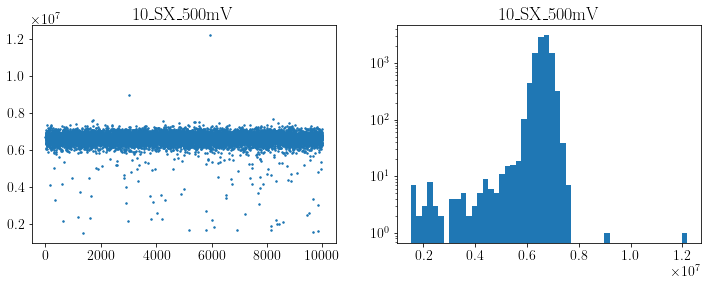

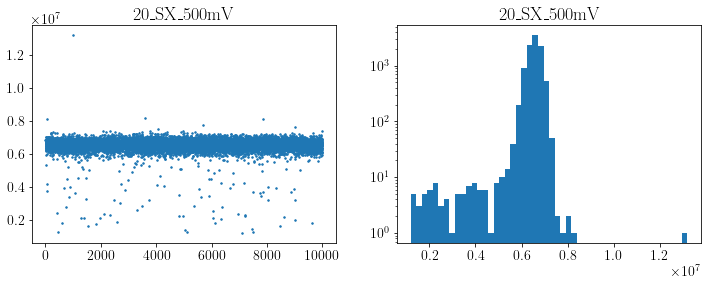

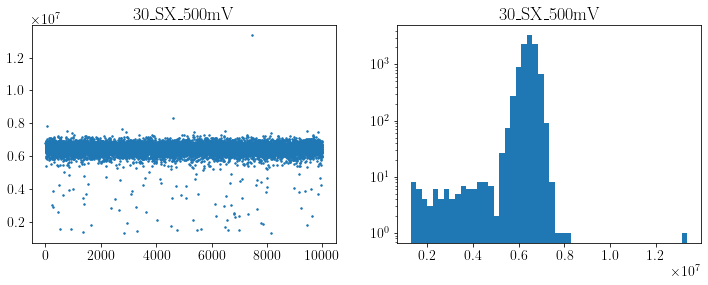

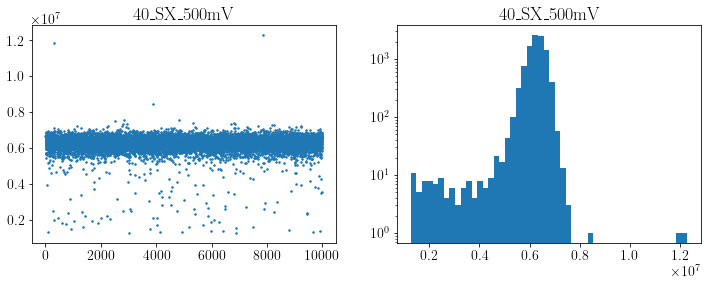

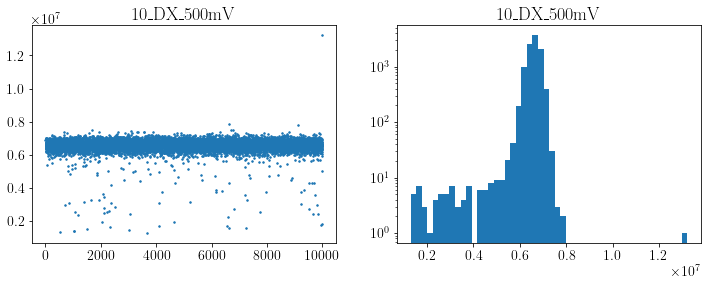

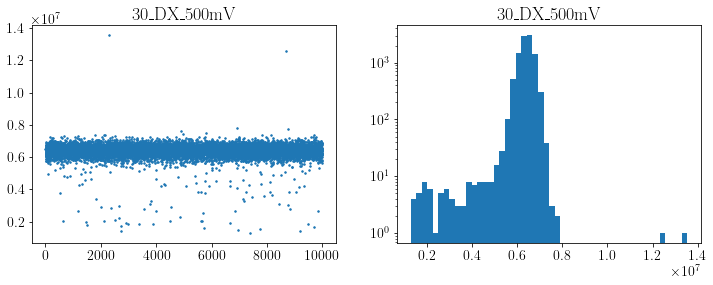

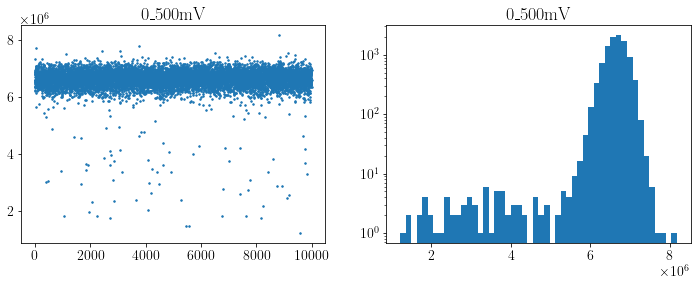

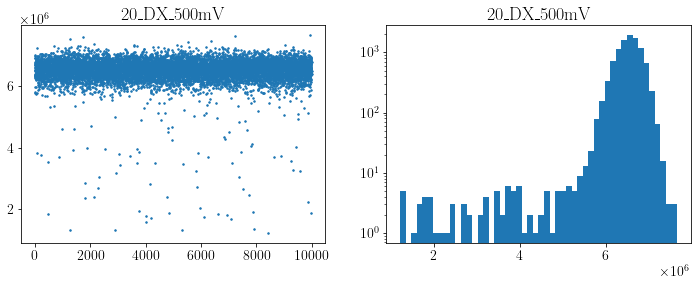

In [11]:
angles = []
events = []
err_angles = []
err_events = []

pico_step = []
pico_rad  = []
pico_deg  = []
pico_seg  = []
pico_ev   = []
pico_t    = []
pico_r    = []

pico_step_err = []
pico_rad_err  = []
pico_deg_err  = []
pico_ev_err   = []
pico_r_err    = []



os.chdir(DATA_PATH)
for d in os.listdir("."):
    # print(d)
    os.chdir(d)
    run = d.split("_")[0]
    
    #######################################################################
    # CHECK TRIGGER
    #######################################################################
    if (str(TRG)+"mV") not in d:
        os.chdir(DATA_PATH)
        continue
    #######################################################################
    
    #######################################################################
    # TAKE DIRECTION FROM DIR NAME
    #######################################################################
    if "DX" in d:
        sign = -1
    elif "SX" in d:
        sign = +1
    else:
        sign = 0
    #######################################################################

    #######################################################################
    # TAKE DATA FROM run FILE
    #######################################################################
    file = open("run")
    line = file.readlines()
    for l in line:
        if (l.startswith("n_segments")):
            n_seg = int(l.split('=')[1].strip())
            pico_seg.append(n_seg)
        if (l.startswith("run_time")):
            run_time = int(l.split('=')[1].strip())
    file.close()
    
    steps = sign * int(''.join(filter(lambda i: i.isdigit(), run))) # - SC
    #######################################################################
    
    #######################################################################
    # TAKE DATA FROM run_BlockTimes.txt
    #######################################################################
    times  = np.loadtxt("run_BlockTimes.txt")
    blocks = times.shape[0]
    events = blocks * n_seg
    # print(times.shape)
    if times.shape != (2,):
        t  = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])
    else:
        t  = run_time

    pico_step.append(steps)
    pico_rad.append(steps * 0.9 * np.pi / 180.0)
    pico_deg.append(steps * 0.9)
    pico_t.append(t)
    pico_ev.append(events)
    pico_r.append(events / t * 3600)
    #######################################################################
    
    #######################################################################
    # COMPUTE ERRORS
    #######################################################################
    pico_step_err.append(0.05) # 1.0 / np.sqrt(12.0)
    pico_rad_err .append(0.05 * 0.9 * np.pi / 180.0)
    pico_deg_err .append(0.05 * 0.9)
    pico_ev_err  .append(np.sqrt(events))
    pico_r_err   .append(np.sqrt(events) / t * 3600)
    #######################################################################

    
    #######################################################################
    # TAKE DATA FROM ALL WAVEFORMS
    #######################################################################
    if WAVE2NUMPY:
        data     = np.load(d+".npy")
        data_mav = np.apply_along_axis(moving_average, 1, data, M)

        baseline_mask = np.arange(data_mav.shape[1])
        baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

        baseline = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]

        data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        if REJECT_3SIGMA:
            mask_t = np.logical_and(data_mav_int<data_mav_int_mean+data_mav_int_var*3, data_mav_int>data_mav_int_mean-data_mav_int_var*3)
            mask_f = np.logical_not(mask_t)
        else:
            mask_t = np.ones(data_mav_int.shape, dtype=bool)
            mask_f = np.logical_not(mask_t)

        if PLOT_WAVE:
            fig=plt.figure(figsize=(12, 4))
            plt.subplot(1,2,1)
            if mask_f.shape[0] != 0:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
                plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)
            else:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
            plt.title(d.replace("_", "\_"))

            plt.subplot(1,2,2)
            if mask_f.shape[0] != 0:
                plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
            else:
                plt.hist(data_mav_int[mask_t], bins=50, stacked=True)
            plt.yscale("log")
            plt.title(d.replace("_", "\_"))
            plt.show()
    #######################################################################

    os.chdir(DATA_PATH)

### Events distribution

In [12]:
col = palette.brewer['RdYlGn'][10]

In [13]:
d = {
    "pico_step"     : pico_step,
    "pico_rad"      : pico_rad,
    "pico_deg"      : pico_deg,
    "pico_seg"      : pico_seg,
    "pico_ev"       : pico_ev,
    "pico_t"        : pico_t,
    "pico_r"        : pico_r,
    "pico_step_err" : pico_step_err,
    "pico_rad_err"  : pico_rad_err,
    "pico_deg_err"  : pico_deg_err,
    "pico_ev_err"   : pico_ev_err,
    "pico_r_err"    : pico_r_err
}

df = pd.DataFrame(data=d)
df = df.sort_values(by=['pico_step'])

In [14]:
mean = np.average(df["pico_r"], weights=(1/np.square(df["pico_r_err"])))

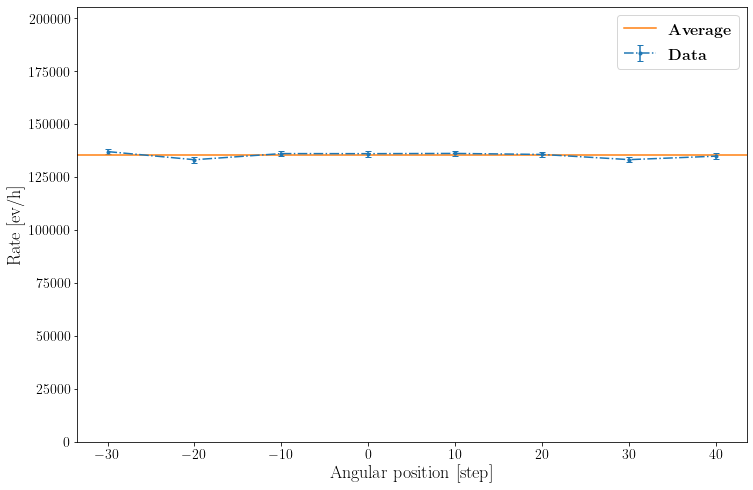

In [15]:
plt.figure(figsize=(12,8))

plt.errorbar(
    x               = df["pico_step"],
    y               = df["pico_r"],
    # xerr            = df_exp["pico_step_err"],
    yerr            = df["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    # markerfacecolor = col[0],
    # color           = col[1],
    # ecolor          = col[0],
    label           = r"\bf{Data}",
    alpha           = 1
)

plt.axhline(
    y    =mean,
    color="C1",
    linewidth=1.5,
    label=r"\bf{Average}"
)

plt.ylim(np.max(df["pico_r"])*0.0, np.max(df["pico_r"])*1.5)
plt.xlabel("Angular position [step]")
plt.ylabel("Rate [ev/h]")
plt.legend()
plt.show()

## Save data

In [16]:
if SAVE_DATA:
    df.to_csv(SAVE_PATH + "pico_data_isotropy.csv", index=False)

## Calibration

### Calibration in 0

In [17]:
E_MU_MEV = 4.827

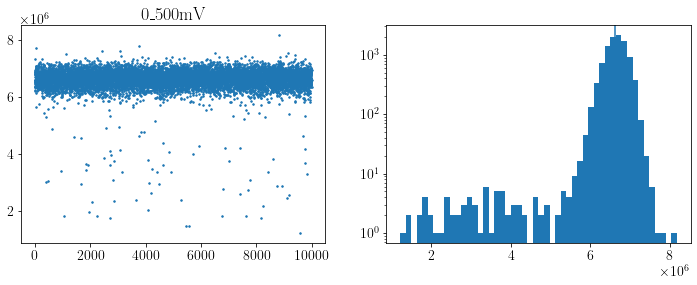

In [18]:
os.chdir(DATA_PATH + "0_500mV")
d   = "0_500mV"
run = d.split("_")[0]

#######################################################################
# TAKE DATA FROM run FILE
#######################################################################
file = open("run")
line = file.readlines()
for l in line:
    if (l.startswith("n_segments")):
        n_seg = int(l.split('=')[1].strip())
        pico_seg.append(n_seg)
    if (l.startswith("run_time")):
        run_time = int(l.split('=')[1].strip())
file.close()
    
#######################################################################
# TAKE DATA FROM run_BlockTimes.txt
#######################################################################
times  = np.loadtxt("run_BlockTimes.txt")
blocks = times.shape[0]
events = blocks * n_seg
# print(times.shape)
if times.shape != (2,):
    t  = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])
else:
    t  = run_time
#######################################################################


#######################################################################
# TAKE DATA FROM ALL WAVEFORMS
#######################################################################
if WAVE2NUMPY:
    data     = np.load("0_500mV.npy")
    data_mav = np.apply_along_axis(moving_average, 1, data, M)

    baseline_mask = np.arange(data_mav.shape[1])
    baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

    baseline = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]

    data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]
    
    E_MU_AU = np.mean(data_mav_int)

    data_mav_int_mean = np.mean(data_mav_int)
    data_mav_int_var  = np.std(data_mav_int)

    if REJECT_3SIGMA:
        mask_t = np.logical_and(data_mav_int<data_mav_int_mean+data_mav_int_var*3, data_mav_int>data_mav_int_mean-data_mav_int_var*3)
        mask_f = np.logical_not(mask_t)
    else:
        mask_t = np.ones(data_mav_int.shape, dtype=bool)
        mask_f = np.logical_not(mask_t)

    if PLOT_WAVE:
        fig=plt.figure(figsize=(12, 4))
        plt.subplot(1,2,1)
        if mask_f.shape[0] != 0:
            plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
            plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)
        else:
            plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
        plt.title(d.replace("_", "\_"))

        plt.subplot(1,2,2)
        if mask_f.shape[0] != 0:
            plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
        else:
            plt.hist(data_mav_int[mask_t], bins=50, stacked=True)
        plt.axvline(E_MU_AU)
        plt.yscale("log")
        plt.show()


#######################################################################
os.chdir(DATA_PATH)

In [19]:
print(E_MU_AU)

6627023.351397143


### Calibrate all and take centroids

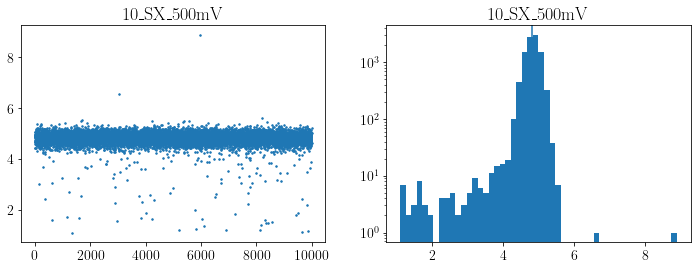

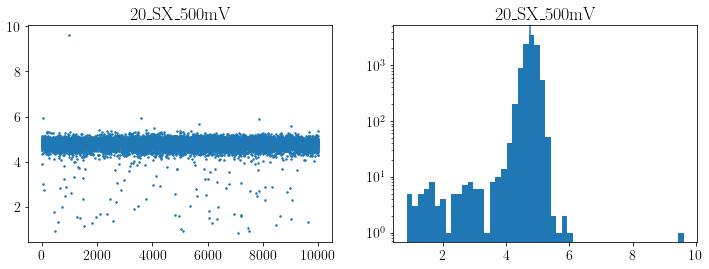

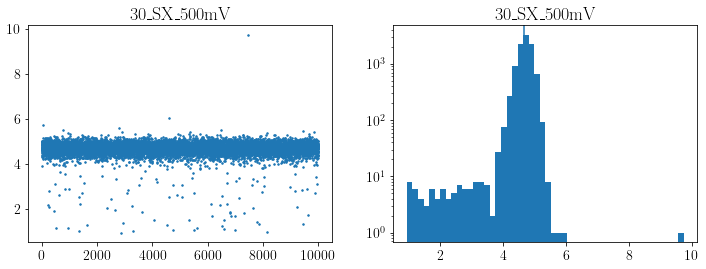

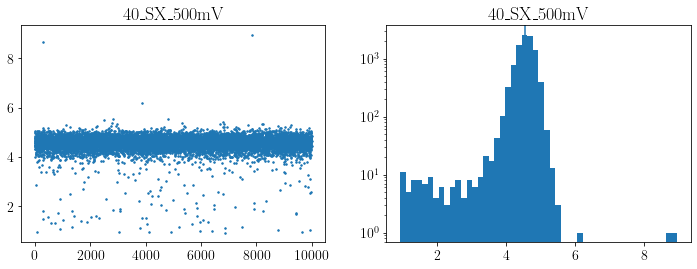

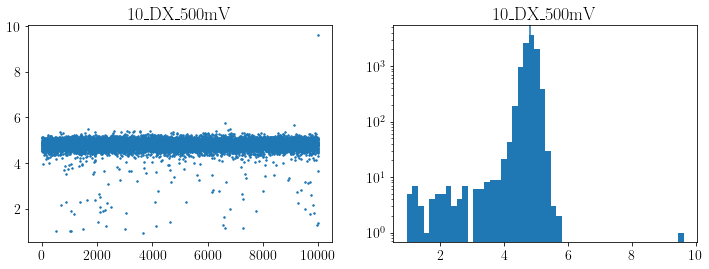

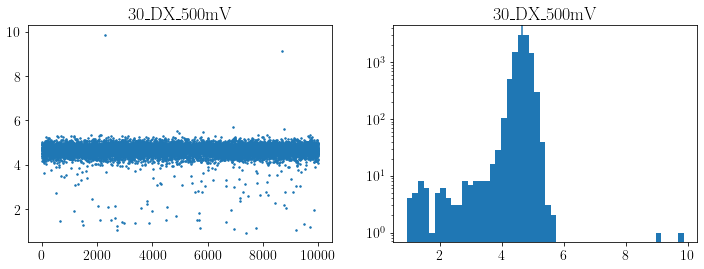

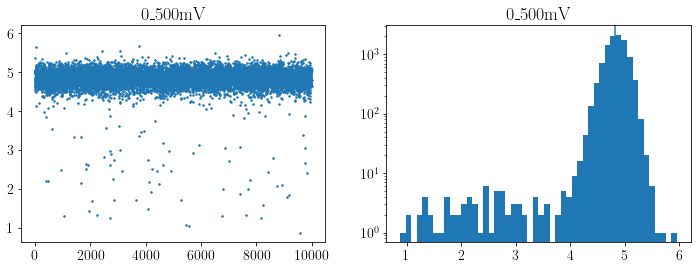

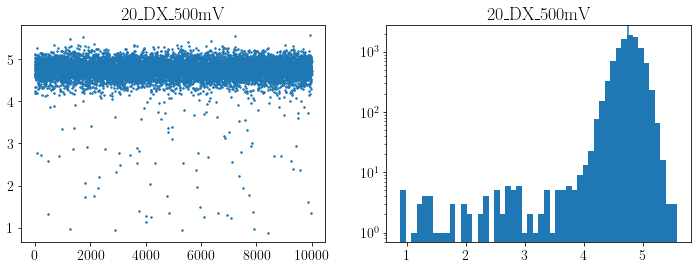

In [20]:
angles = []
events = []
err_angles = []
err_events = []

pico_step = []
pico_rad  = []
pico_deg  = []
pico_seg  = []
pico_ev   = []
pico_t    = []
pico_r    = []

pico_step_err = []
pico_rad_err  = []
pico_deg_err  = []
pico_ev_err   = []
pico_r_err    = []

pico_e_mu     = []
pico_e_mu_err = []



os.chdir(DATA_PATH)
for d in os.listdir("."):
    # print(d)
    os.chdir(d)
    run = d.split("_")[0]
    
    #######################################################################
    # CHECK TRIGGER
    #######################################################################
    if (str(TRG)+"mV") not in d:
        os.chdir(DATA_PATH)
        continue
    #######################################################################
    
    #######################################################################
    # TAKE DIRECTION FROM DIR NAME
    #######################################################################
    if "DX" in d:
        sign = -1
    elif "SX" in d:
        sign = +1
    else:
        sign = 0
    #######################################################################

    #######################################################################
    # TAKE DATA FROM run FILE
    #######################################################################
    file = open("run")
    line = file.readlines()
    for l in line:
        if (l.startswith("n_segments")):
            n_seg = int(l.split('=')[1].strip())
            pico_seg.append(n_seg)
        if (l.startswith("run_time")):
            run_time = int(l.split('=')[1].strip())
    file.close()
    
    steps = sign * int(''.join(filter(lambda i: i.isdigit(), run))) # - SC
    #######################################################################
    
    #######################################################################
    # TAKE DATA FROM run_BlockTimes.txt
    #######################################################################
    times  = np.loadtxt("run_BlockTimes.txt")
    blocks = times.shape[0]
    events = blocks * n_seg
    # print(times.shape)
    if times.shape != (2,):
        t  = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])
    else:
        t  = run_time

    pico_step.append(steps)
    pico_rad.append(steps * 0.9 * np.pi / 180.0)
    pico_deg.append(steps * 0.9)
    pico_t.append(t)
    pico_ev.append(events)
    pico_r.append(events / t * 3600)
    #######################################################################
    
    #######################################################################
    # COMPUTE ERRORS
    #######################################################################
    pico_step_err.append(0.05) # 1.0 / np.sqrt(12.0)
    pico_rad_err .append(0.05 * 0.9 * np.pi / 180.0)
    pico_deg_err .append(0.05 * 0.9)
    pico_ev_err  .append(np.sqrt(events))
    pico_r_err   .append(np.sqrt(events) / t * 3600)
    #######################################################################

    
    #######################################################################
    # TAKE DATA FROM ALL WAVEFORMS
    #######################################################################
    if WAVE2NUMPY:
        data     = np.load(d+".npy")
        data_mav = np.apply_along_axis(moving_average, 1, data, M)

        baseline_mask = np.arange(data_mav.shape[1])
        baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

        baseline = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]

        data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]
        data_mav_int = data_mav_int * (E_MU_MEV / E_MU_AU)

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_std  = np.std(data_mav_int)
        
        pico_e_mu.append(data_mav_int_mean)
        pico_e_mu_err.append(data_mav_int_std / np.sqrt(data_mav_int.shape[0]-1))
        
        mask_t = np.ones(data_mav_int.shape, dtype=bool)
        mask_f = np.logical_not(mask_t)

        if PLOT_WAVE:
            fig=plt.figure(figsize=(12, 4))
            plt.subplot(1,2,1)
            if mask_f.shape[0] != 0:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
                plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)
            else:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
            plt.title(d.replace("_", "\_"))

            plt.subplot(1,2,2)
            if mask_f.shape[0] != 0:
                plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
            else:
                plt.hist(data_mav_int[mask_t], bins=50, stacked=True)
            plt.axvline(data_mav_int_mean)
            plt.yscale("log")
            plt.title(d.replace("_", "\_"))
            plt.show()
    #######################################################################

    os.chdir(DATA_PATH)

### Print centroids and errors

In [21]:
print("Steps:    ", pico_step)
print("Centroids:", pico_e_mu)
print("Errors:   ", pico_e_mu_err)

Steps:     [10, 20, 30, 40, -10, -30, 0, -20]
Centroids: [4.808049846755624, 4.758173581744458, 4.67858481122675, 4.540828864005723, 4.7930161354921275, 4.655413583151938, 4.827, 4.745904677126155]
Errors:    [0.002895491362088362, 0.0031016935650802885, 0.0032194357986686816, 0.0036494888154237947, 0.0029736915011981018, 0.0031753949832983787, 0.0028437237508075943, 0.002988471342456533]


### Plot data and fit

In [22]:
# scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=- inf, inf, method=None, jac=None, **kwargs)

#### Fit function

In [23]:
def f(x, a, b, c):
    return a + b/np.cos((x-c)*0.9*np.pi/180.0)

#### Fit data

In [24]:
fit = curve_fit(f, pico_step, pico_e_mu)

#### Compute predicted data

In [43]:
pico_step_c     = np.array([-40] + pico_step)
pico_e_mu_c     = np.array([4.510] + pico_e_mu)
pico_e_mu_err_c = np.array([0.003] + pico_e_mu_err)

In [41]:
pred_e_mu_c = f(np.array(pico_step_c), fit[0][0], fit[0][1], fit[0][2])

#### Put in dataframe

In [44]:
d = {
    "pico_step"     : pico_step_c,
    "pico_rad"      : pico_step_c * 0.9 * np.pi/180.0,
    "pico_deg"      : pico_step_c * 0.9,
    "pico_e_mu"     : pico_e_mu_c,
    "pred_e_mu"     : pred_e_mu_c,
    "pico_step_err" : 0.05,
    "pico_rad_err"  : 0.05 * 0.9 * np.pi/180.0,
    "pico_deg_err"  : 0.05 * 0.9,
    "pico_e_mu_err" : pico_e_mu_err_c,
}

df = pd.DataFrame(data=d)
df = df.sort_values(by=['pico_step'])

In [46]:
df

,pico_step,pico_rad,pico_deg,pico_e_mu,pred_e_mu,pico_step_err,pico_rad_err,pico_deg_err,pico_e_mu_err
0,-40,-0.628319,-36.0,4.510000,4.503652,0.05,0.000785,0.045,0.003000
6,-30,-0.471239,-27.0,4.655414,4.653462,0.05,0.000785,0.045,0.003175
8,-20,-0.314159,-18.0,4.745905,4.747343,0.05,0.000785,0.045,0.002988
5,-10,-0.157080,-9.0,4.793016,4.800141,0.05,0.000785,0.045,0.002974
7,0,0.000000,0.0,4.827000,4.819153,0.05,0.000785,0.045,0.002844
1,10,0.157080,9.0,4.808050,4.806831,0.05,0.000785,0.045,0.002895
2,20,0.314159,18.0,4.758174,4.761597,0.05,0.000785,0.045,0.003102
3,30,0.471239,27.0,4.678585,4.677320,0.05,0.000785,0.045,0.003219
4,40,0.628319,36.0,4.540829,4.541124,0.05,0.000785,0.045,0.003649


#### Save dataframe

In [47]:
if SAVE_DATA:
    df.to_csv(SAVE_PATH + "pico_data_correlation.csv", index=False)

#### Save parameters

In [54]:
if SAVE_DATA:
    np.save(SAVE_PATH + "pico_data_correlation_pars.npy", fit[0])
    np.save(SAVE_PATH + "pico_data_correlation_cov.npy",  fit[1])

#### Plot

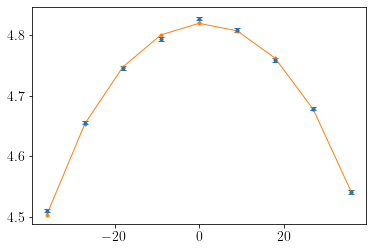

In [49]:
plt.errorbar(
    x          = df["pico_deg"],
    y          = df["pico_e_mu"],
    yerr       = df["pico_e_mu_err"],
    markersize = 3,
    capsize    = 3,
    fmt        = "o"
)
plt.plot(
    df["pico_deg"],
    df["pred_e_mu"],
    "-o",
    markersize = 3,
    linewidth  = 1
)
plt.show()